In [84]:
from torchvision import datasets
from torchvision import transforms
import torchvision.models as models
import torch.nn as nn
import torch
import random
from collections import OrderedDict
import torch.nn.functional as F

from torch.distributions.categorical import Categorical

from sklearn.manifold import TSNE
from sklearn.datasets import load_iris
from numpy import reshape
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [20]:
import math
from torch import nn
import torch
from copy import deepcopy

class CustomBN(nn.Module):
    def __init__(self, options):
        super(CustomBN, self).__init__()
        # normal, detach, omit
        self.mean = options["mean"]

        # normal, detach, omit
        self.std = options["std"]

    def forward(self, x):
        if self.mean == "detach":
            x = x - x.mean(0).detach()
        elif self.mean == "normal":
            x = x - x.mean(0)
        elif self.mean == "omit":
            pass
        else:
            raise NotImplementedError(f"The mean normalization {self.mean} is not implemented!")

        if self.std == "detach":
            x = x / (x.var(0).detach() + 1e-5).sqrt()
        elif self.std == "normal":
            x = x / (x.var(0) + 1e-5).sqrt()
        elif self.std == "omit":
            pass
        else:
            raise NotImplementedError(f"The std normalization {self.std} is not implemented!")

        return x

class MLPHead(nn.Module):
    def __init__(self, in_channels, mlp_hidden_size, projection_size, options=None):
        super(MLPHead, self).__init__()
        if options is None:
            options = dict(normalization="bn", has_bias=True, has_bn_affine=False, has_relu=True, additional_bn_at_input=False, custom_nz=None)

        assert options["custom_nz"] == "grad_act_zero" or options["custom_nz"] is None

        bn_size = in_channels if mlp_hidden_size is None else mlp_hidden_size
        l = self._create_normalization(bn_size, options)

        if options["additional_bn_at_input"]:
            l_before = nn.BatchNorm1d(in_channels, affine=False)
        else:
            l_before = None

        # assert "OriginalBN" in option
        layers = []

        if l_before is not None:
            layers.append(l_before)

        if mlp_hidden_size is not None:
            layers.append(nn.Linear(in_channels, mlp_hidden_size, bias=options["has_bias"]))
            if l is not None:
                layers.append(l)
            if options["has_relu"]:
                layers.append(nn.ReLU(inplace=True))
        else:
            if l is not None:
                layers.append(l)

        layers.append(nn.Linear(bn_size, projection_size, bias=options["has_bias"]))
        self.layers = nn.ModuleList(layers)
        self.gradW = [ None for _ in self.layers ]
        self.masks = [ None for _ in self.layers ]
        self.prods = [ list() for _ in self.layers ]
        self.custom_nz = options["custom_nz"]
        self.compute_adj_grad = True

    def _create_normalization(self, size, options):
        # nn.BatchNorm1d(mlp_hidden_size),
        method = options["normalization"]
        if method == "bn":
            l = nn.BatchNorm1d(size, affine=options["has_bn_affine"])
        elif method == "custom_bn":
            l = CustomBN(options["custom_bn"])
        elif method == "no_normalization":
            l = None
        else:
            raise NotImplementedError(f"The normalization {method} is not implemented yet!")
        return l

    def _compute_reg(self, g, f, x):
        # g: n_batch x n_output
        # f: n_batch x n_output
        # x: n_batch x n_input
        # return inner_prod(g[i,:], f[i,:]) * outer_prod(g[i,:], x[i,:])
        with torch.no_grad():
            prod = (g * f).sum(dim=1, keepdim=True)
            # n_batch x n_output x n_input
            return prod, torch.bmm(g.unsqueeze(2), x.unsqueeze(1)) * prod.unsqueeze(2)

    def _grad_hook(self, g, f, x, i):
        # extra weight update. 
        # gradW = [n_output x n_input]
        # Generate a random mask. 
        mask = (torch.rand(g.size(1)) > 0.5).to(device=g.get_device())
        prod, self.gradW[i] = self._compute_reg(g[:,mask], f[:,mask], x)
        self.gradW[i] = self.gradW[i].mean(dim=0) 
        self.masks[i] = mask
        self.prods[i].append((g * f).norm().item() / math.sqrt(g.size(0) * g.size(1)))
        return None

    def forward(self, x):
        for i, l in enumerate(self.layers):
            f = l(x)
            if self.compute_adj_grad and isinstance(l, nn.Linear) and self.custom_nz == "grad_act_zero":
                # Add a backward hook to accumulate gradient for weight normalization.
                # We want E[g f] = 0. 
                #     g: n_batch x n_output 
                #     f: n_batch x n_output  
                # If we want to make it per sample, we would want to achieve g[i,:] . f[i,:] = 0
                #     or x[i,:] W g[i,:]' = 0 
                f.register_hook(lambda g, f=f, x=x, i=i: self._grad_hook(g, f, x, i))
            # For the next layer.
            x = f
        return x

    def set_adj_grad(self, compute_adj_grad):
        self.compute_adj_grad = compute_adj_grad

    def adjust_grad(self):
        with torch.no_grad():
            for l, mask, gW in zip(self.layers, self.masks, self.gradW):
                if gW is not None:
                    # mask = Output mask.
                    # we don't want to add an additional weight decay, so the direction should be orthogonal to l.weight.
                    w = l.weight[mask,:]
                    coeff = (gW * w).sum() / w.pow(2).sum()
                    gW -= coeff * w
                    l.weight.grad[mask,:] += 100 * gW

        self.gradW = [ None for _ in self.layers ]

    def normalize(self):
        if self.custom_nz == "grad_act_zero":
            # Normalize all linear weight. 
            with torch.no_grad():
               for l in self.layers:
                   if isinstance(l, nn.Linear):
                       l.weight /= l.weight.norm()

    def get_stats(self):
        if self.custom_nz == "grad_act_zero":
            s = "grad_act_zero: \n"
            for i, (p, l) in enumerate(zip(self.prods, self.layers)):
                if len(p) > 0:
                    s += f"[{i}]: norm: {l.weight.norm()}, mean(f*g): start: {p[0]}, end: {p[-1]}\n"
                    p.clear()

            return s
        return None

In [21]:
class Conv2dExtBase(nn.Module):
    def __init__(self, name, conv, conv_spec):
        super(Conv2dExtBase, self).__init__()
        self.name = name
        self.conv = conv
        # Add a bunch of hook to monitor the input and gradInput.
        self.conv.register_backward_hook(self._backward_hook)

        self.conv_spec = conv_spec
        self.filter_grad_sqr = None
        self.relu_stats = None
        self.cnt = 0

    def _backward_hook(self, _, grad_input, grad_output):
        if not self.training:
            return

        grad_output = grad_output[0]
        with torch.no_grad():
            # compute statistics. 
            out_channels = self.conv.out_channels

            # [batch, C, H, W]
            this_filter_grad_sqr = grad_output.pow(2).sum(dim=(0,2,3)).detach()
            this_relu_stats = (grad_output.abs() > 1e-8).long().sum(dim=(0,2,3)).detach() 

            if self.filter_grad_sqr is not None:
                self.filter_grad_sqr += this_filter_grad_sqr 
                self.relu_stats += this_relu_stats
            else:
                self.filter_grad_sqr = this_filter_grad_sqr 
                self.relu_stats = this_relu_stats
                assert self.filter_grad_sqr.size(0) == out_channels 

            self.cnt += 1

        return None

    def _clean_up(self):
        self.cnt = 0
        self.filter_grad_sqr.fill_(0)
        self.relu_stats.fill_(0)

    def forward(self, x):
        return self.conv(x)


class Conv2dExtSetIndependent(Conv2dExtBase):
    def __init__(self, name, conv, conv_spec):
        super(Conv2dExtSetIndependent, self).__init__(name, conv, conv_spec)
        # Add a bunch of hook to monitor the input and gradInput.
        self.conv.register_forward_hook(self._forward_hook)

        self.change_weight_this_round = False

        out_channels = self.conv.out_channels
        self.num_sample = int(self.conv_spec["resample_ratio"] * out_channels) 

    def _forward_hook(self, _, input, output):
        if not self.change_weight_this_round:
            return

        # Record input and output
        self.input = input[0].clone()
        self.output = output.clone()

    def pre_process(self):
        if not self.training:
            return

        self.change_weight_this_round = True

    # finally, once the backward is done, we modify the weights accordingly. 
    def post_process(self):
        if not self.change_weight_this_round:
            return

        with torch.no_grad():
            # Check all gradient_at_output level and find which filter has the lowest 
            self.filter_grad_sqr /= self.cnt
            # from smallest to highest.
            sorted_stats, indices = self.filter_grad_sqr.sort()

            # For filter with the lowest gradient_at_output, we want to replace it with patterns that is the least received (i.e., no filter responds strongly with it)
            # scores = [B, H, W]
            scores = self.output.clamp(min=0).mean(dim=1)

            # cut padding
            kh, kw = self.conv.kernel_size
            sh, sw = kh // 2, kw // 2
            scores = scores[:, sh:-sh,sw:-sw].contiguous()

            # need to normalize per sample.
            scores = scores / (scores.mean(dim=(1,2),keepdim=True) + 1e-6)

            # average norm of weight. 
            norms = self.conv.weight.view(out_channels, -1).norm(dim=1)
            avg_norm = norms.mean()

            # then we sample scores, the low the score is, the higher the probability is. 
            sampler = Categorical(logits=scores.view(-1) / (scores.max() + 1e-8) * -4) 

            sel_indices = []
            for i in range(self.num_sample): 
                # import pdb
                # pdb.set_trace()
                loc_idx = sampler.sample().item()

                w_idx = loc_idx % scores.size(2)
                hb_idx = loc_idx // scores.size(2)
                h_idx = hb_idx % scores.size(1)
                b_idx = hb_idx // scores.size(1) 

                # The lowest i-th filter to be replaced. 
                filter_idx = indices[i].item()
                sel_indices.append((loc_idx, filter_idx))

                # Directly assign weights!
                patch = self.input[b_idx, :, h_idx:h_idx+kh, w_idx:w_idx+kw]
                patch_norm = patch.norm()
                if patch_norm >= 1e-6:
                    patch = patch / patch_norm * avg_norm
                    self.conv.weight[filter_idx,:,:,:] = patch
                    if self.conv.bias is not None:
                        self.conv.bias[filter_idx] = -avg_norm / 2

            # log.debug(f"Update conv2d weight. freq = {self.conv_spec['reset_freq']}, ratio = {self.conv_spec['resample_ratio']}, loc_indices = {sel_indices} out of size {scores.size()}")
            '''
            prompt = f"Conv2d[{self.name}] " + \
                     f"min/max filter grad = {sorted_stats[0]:.4e}/{sorted_stats[-1]:.4e}, " + \
                     f"avg selected = {sorted_stats[:self.num_sample].mean().item():.4e}"
            log.debug(prompt)
            '''
            # reset counters. 
            self.change_weight_this_round = False
            self._clean_up()


class Conv2dExtSetDiff(Conv2dExtBase):
    def __init__(self, name, conv, conv_spec):
        super(Conv2dExtSetDiff, self).__init__(name, conv, conv_spec)

        # Add a bunch of hook to monitor the input and gradInput.
        self.conv.register_forward_pre_hook(self._forward_prehook)
        self.pairs_of_samples = None

        out_channels = self.conv.out_channels
        self.num_sample = int(self.conv_spec["resample_ratio"] * out_channels) 

    def _forward_prehook(self, _, input):
        if not self.training or self.pairs_of_samples is None:
            return

        input = input[0]
        kh, kw = self.conv.kernel_size
        sh, sw = kh // 2, kw // 2
        # input = input[:, :, sh:-sh,sw:-sw].contiguous()

        out_channels = self.conv.out_channels

        with torch.no_grad():
            # Compute the norm of local patches. 
            uniform_weight = self.conv.weight[0].clone().fill_(1.0)
            # Local sum
            # local_energy = [batchsize, H - kH + 1, W - kW + 1]
            local_energy = F.conv2d(input.pow(2), uniform_weight.unsqueeze(0)).squeeze(1).sqrt()
            # sample from local energy
            # average norm of weight. 
            norms = self.conv.weight.view(out_channels, -1).norm(dim=1)
            avg_norm = norms.mean()

            sorted_stats, filter_indices = self.filter_grad_sqr.sort()

            # For filter with the lowest gradient_at_output, we want to replace it with pairs of input patterns 
            indices = filter_indices.tolist()
            for k, (i, j) in zip(indices[:self.num_sample], self.pairs_of_samples):
                # replace the filter with a random patch difference. 
                # We can also pick the location where patch energy is maximized spatially. 
                # score = [H - kH + 1, W - kW + 1]
                score = (local_energy[i] + local_energy[j]) * 3 
                sampler = Categorical(logits=score.view(-1)) 
                loc_idx = sampler.sample().item()

                h_idx = loc_idx // score.size(1)
                w_idx = loc_idx % score.size(1)
                # h_idx = random.randint(0, input.size(2) - kh)
                # w_idx = random.randint(0, input.size(3) - kw)

                patch = input[i,:,h_idx:h_idx+kh, w_idx:w_idx+kw] - input[j,:,h_idx:h_idx+kh, w_idx:w_idx+kw] 
                patch_norm = patch.norm()
                if patch_norm >= 1e-6:
                    patch = patch / patch_norm * avg_norm
                    self.conv.weight[k,:,:,:] = patch
                    if self.conv.bias is not None:
                        self.conv.bias[k] = 0
        
        self.pairs_of_samples = None
        self._clean_up()

    def pre_process(self, pairs_of_samples):
        self.pairs_of_samples = pairs_of_samples

    def post_process(self):
        pass


# Customized BatchNorm
class BatchNorm2dExt(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1, backprop_mean=True, backprop_var=True):
        super(BatchNorm2dExt, self).__init__()

        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.backprop_mean = backprop_mean
        self.backprop_var = backprop_var

        # Tracking stats
        self.register_buffer("running_mean", torch.zeros(num_features))
        self.register_buffer("running_var", torch.ones(num_features))

    def forward(self, x):
        assert len(x.size()) == 4

        if self.training: 
            # Note the detach() here. Standard BN also needs to backprop through mean/var, creating projection matrix in the Jakobian
            this_mean = x.mean(dim=(0,2,3))
            this_var = x.var(dim=(0,2,3), unbiased=False)

            if not self.backprop_mean:
                this_mean = this_mean.detach()

            if not self.backprop_var:
                this_var = this_var.detach()
            
            x = (x - this_mean[None,:,None,None]) / (this_var[None,:,None,None] + self.eps).sqrt()
            # Tracking stats
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * this_mean.detach()
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * this_var.detach()
        else:
            # Just use current running_mean/var
            x = (x - self.running_mean[None,:,None,None]) / (self.running_var[None,:,None,None] + self.eps).sqrt()

        return x

Conv2dExt = Conv2dExtSetDiff

class ExtendedBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, name, basic_block, bn_spec=None, conv_spec=None):
        super(ExtendedBasicBlock, self).__init__()
        for key in ["conv1", "bn1", "relu", "conv2", "bn2", "downsample", "stride"]:
            setattr(self, key, getattr(basic_block, key)) 

        self.name = name
        self.bn_spec = bn_spec
        self.conv_spec = conv_spec

        bn_variant = bn_spec["bn_variant"]
        if bn_variant == "no_affine":
            # do not put affine. 
            self.bn1 = nn.BatchNorm2d(self.bn1.weight.size(0), self.bn1.eps, self.bn1.momentum, affine=False)
            self.bn2 = nn.BatchNorm2d(self.bn2.weight.size(0), self.bn2.eps, self.bn2.momentum, affine=False)
        elif bn_variant == "no_proj":
            self.bn1 = BatchNorm2dExt(self.bn1.weight.size(0), self.bn1.eps, self.bn1.momentum, backprop_mean=False, backprop_var=False)
            self.bn2 = BatchNorm2dExt(self.bn2.weight.size(0), self.bn2.eps, self.bn2.momentum, backprop_mean=False, backprop_var=False)
        elif bn_variant == "proj_only_mean":
            self.bn1 = BatchNorm2dExt(self.bn1.weight.size(0), self.bn1.eps, self.bn1.momentum, backprop_mean=True, backprop_var=False)
            self.bn2 = BatchNorm2dExt(self.bn2.weight.size(0), self.bn2.eps, self.bn2.momentum, backprop_mean=True, backprop_var=False)
        elif bn_variant == "proj_only_var":
            self.bn1 = BatchNorm2dExt(self.bn1.weight.size(0), self.bn1.eps, self.bn1.momentum, backprop_mean=False, backprop_var=True)
            self.bn2 = BatchNorm2dExt(self.bn2.weight.size(0), self.bn2.eps, self.bn2.momentum, backprop_mean=False, backprop_var=True)
        elif bn_variant == "no_affine_custom":
            self.bn1 = BatchNorm2dExt(self.bn1.weight.size(0), self.bn1.eps, self.bn1.momentum, backprop_mean_var=True)
            self.bn2 = BatchNorm2dExt(self.bn2.weight.size(0), self.bn2.eps, self.bn2.momentum, backprop_mean_var=True)
        elif bn_variant == "regular":
            pass
        else:
            raise RuntimeError(f"Unknown bn_variant! {bn_variant}")


        conv_variant = self.conv_spec["variant"]
        if conv_variant == "resample":
            layer_involved = self.conv_spec["layer_involved"].split("-")
            assert len(layer_involved) > 0, f"when variant is set to be resample, layer_involved should contain > 0 entries"
            for layer_name in layer_involved:
                setattr(self, layer_name, Conv2dExt(self.name + "." + layer_name, getattr(self, layer_name), self.conv_spec)) 
        elif conv_variant == "regular":
            pass
        else:
            raise RuntimeError(f"Unknown conv_variant! {conv_variant}")

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        if self.bn_spec["enable_bn1"]:
            out = self.bn1(out)

        out = self.relu(out)

        out = self.conv2(out)

        if self.bn_spec["enable_bn2"]:
            out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

    def call_func(self, func_name, *args, **kwargs):
        if isinstance(self.conv1, Conv2dExt):
            getattr(self.conv1, func_name)(*args, **kwargs) 
        if isinstance(self.conv2, Conv2dExt):
            getattr(self.conv2, func_name)(*args, **kwargs) 

def change_layers(name_prefix, model, **kwargs):
    output = OrderedDict()

    for name, module in model.named_children():
        this_prefix = name_prefix + "." + name if name_prefix != "" else name
        if isinstance(module, models.resnet.BasicBlock):
            module = ExtendedBasicBlock(this_prefix, module, **kwargs)
            
        if isinstance(module, nn.Sequential):
            module = change_layers(this_prefix, module, **kwargs)

        if module is not None:
            output[name] = module

    return type(model)(output)

class ResNet18(torch.nn.Module):
    def __init__(self, dataset, options, *args, **kwargs):
        super(ResNet18, self).__init__()

        if kwargs['name'] == 'resnet18':
            resnet = models.resnet18(pretrained=False)
        elif kwargs['name'] == 'resnet50':
            resnet = models.resnet50(pretrained=False)

        bn_spec = kwargs["bn_spec"]
        conv_spec = kwargs["conv_spec"]
        self.conv_spec = conv_spec

        self.f = OrderedDict()
        for name, module in resnet.named_children():
            # print(name, module)
            if dataset in ["cifar10", "cifar100"]:
                # For cifar10, we use smaller kernel size in conv2d and no max pooling according to SimCLR paper (Appendix B.9) 
                # https://arxiv.org/pdf/2002.05709.pdf
                if name == 'conv1':
                    module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
                elif isinstance(module, nn.MaxPool2d):
                    module = None
            # Get rid of the last Linear layer to extract the encoder. 
            if isinstance(module, nn.Linear):
                module = None

            if name == "conv1" and conv_spec["include_first_conv"]:
                module = Conv2dExt(name, module, conv_spec)

            if module is not None:
                self.f[name] = module

        # encoder
        self.encoder = nn.Sequential(self.f)
        self.encoder = change_layers("", self.encoder, bn_spec=bn_spec, conv_spec=conv_spec)
        # print(self.encoder)

        self.feature_dim = resnet.fc.in_features
        self.projetion = MLPHead(in_channels=self.feature_dim, **kwargs['projection_head'], options=options)

    def forward(self, x):
        h = self.encoder(x)
        h = h.view(h.shape[0], h.shape[1])
        return self.projetion(h)

    def special_call(self, xs, zs, negative_sim, n_iter):
        if n_iter % self.conv_spec["freq"] != 0:
            return

        # Get closest samples from negative_similarity matrix. 
        # Negative similarity has size 2N x (2N - 2) (i.e., for each sample, remove itself and its corresponding augmented sample)
        dis = 1 - negative_sim
        # some nonlinear transform. 
        # importance = dis * (-dis/0.5).exp()
        importance = -dis
        sorted_importance, sorted_indices = importance.view(-1).sort(descending=True)

        N = xs.size(0) // 2
        num_samples = 50

        # Then each index is a pair. How to decode? 
        samples = []
        for idx in sorted_indices:
            dst_idx = idx % (2 * N - 2)
            # 0 <= src_idx < 2N
            src_idx = idx // (2 * N - 2)
            if src_idx > dst_idx:
                continue

            sim2 = negative_sim[src_idx, dst_idx]

            # For dst_idx, we need to transform it properly
            if src_idx < N:
                if dst_idx >= src_idx:
                    dst_idx += 1
                if dst_idx >= src_idx + N:
                    dst_idx += 1
            else:
                if dst_idx >= src_idx - N:
                    dst_idx += 1
                if dst_idx >= src_idx:
                    dst_idx += 1

            sim = torch.dot(zs[src_idx], zs[dst_idx])

            samples.append(xs[src_idx])
            samples.append(xs[dst_idx])

            if len(samples) == 2 * num_samples:
                break

        # randomly samples a few pairs. 
        # sample_pairs = [(random.randint(0, N-1), random.randint(0, N-1)) for _ in range(5)]
        sample_pairs = [(2*k, 2*k + 1) for k in range(num_samples)]
        self._call_special("pre_process", sample_pairs)
        # Do a forward.
        self(torch.stack(samples, dim=0))
        self._call_special("post_process")

    def _call_special(self, func_name, *args, **kwargs):
        def go_through(m):
            for name, module in m.named_children():
                if isinstance(module, nn.Sequential):
                    go_through(module)
                elif hasattr(module, func_name):
                    getattr(module, func_name)(*args, **kwargs)
                elif hasattr(module, "call_func"):
                    module.call_func(func_name, *args, **kwargs)

        go_through(self.encoder)


In [5]:
mnist_train_data = datasets.MNIST('./', download=True, train=True)
mnist_test_data = datasets.MNIST('./', download=True, train=False)

In [29]:
dataset = 'mnist'

options = {
    'has_bias': True,
    'has_relu': True,
    'custom_nz': None,
    'normalization': 'bn',
    'has_bn_affine': False,
    'additional_bn_at_input': False,
    'custom_bn': {'mean': 'normal', 'std': 'normal'}
}

kwargs = {
    'name': 'resnet18',
    'pretrained_path': 'None',
    'conv_spec': {
        'variant': 'regular',
        'freq': 100,
        'resample_ratio': 0.05,
        'layer_involved': 'conv1-conv2',
        'include_first_conv': False
    }, 'bn_spec': {
        'enable_bn1': True,
        'enable_bn2': True,
        'bn_variant': 'regular'
    },
    'projection_head': {
        'mlp_hidden_size': 512,
        'projection_size': 128
    },
    'predictor_head': {
        'mlp_hidden_size': None,
        'projection_size': 128
    }
}

In [30]:
checkpoint = torch.load('checkpoints/model_final.pth')

In [31]:
model = ResNet18(dataset, options, **kwargs)
model.load_state_dict(checkpoint['online_network_state_dict'])
model.eval()

ResNet18(
  (encoder): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ExtendedBasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ExtendedBasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

In [55]:
test = torch.stack([transform(mnist_test_data[i][0]) for i in range(len(mnist_test_data))])

In [76]:
train = torch.stack([transform(mnist_train_data[i][0]) for i in range(len(mnist_train_data))])

In [77]:
with torch.no_grad():
    embs_test = model(test)

In [78]:
with torch.no_grad():
    embs_train = model(train)

In [135]:
embs_np = embs_train.numpy()

In [85]:
y_train = np.array([mnist_train_data[i][1] for i in range(len(mnist_train_data))])

In [86]:
y_test = np.array([mnist_test_data[i][1] for i in range(len(mnist_test_data))])

In [87]:
from sklearn.linear_model import LogisticRegression

In [88]:
lm = LogisticRegression(max_iter=1000)

In [89]:
lm.fit(embs_train, y_train)

/home/vshirokinskiy/env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [90]:
lm.score(embs_test, y_test)

0.8702

In [179]:
dumped_emb = pd.read_pickle('test_embeddings.pickle')
targ = pd.read_pickle('test_targets.pickle')

In [181]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [196]:
pca = PCA(n_components=2)
scaler = StandardScaler()
z = scaler.fit_transform(dumped_emb.iloc[:])
# z = pca.fit_transform(z) 

In [197]:
tsne = TSNE(n_components=2, verbose=1, random_state=123, n_jobs=8)
z = tsne.fit_transform(z) 

/home/vshirokinskiy/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vshirokinskiy/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.003s...
[t-SNE] Computed neighbors for 10000 samples in 1.981s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.969290
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.519020
[t-SNE] KL divergence after 1000 iterations: 1.585610


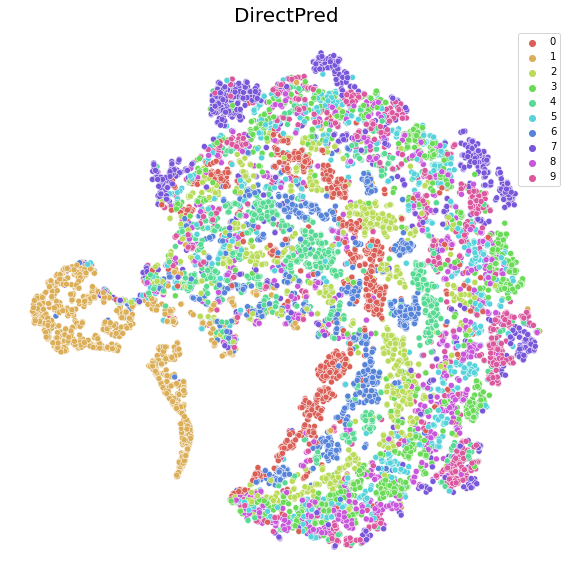

In [204]:
df = pd.DataFrame()
df['y'] = targ[0]
df["comp-1"] = z[:,0]
df["comp-2"] = z[:,1]

fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x="comp-1", y="comp-2", hue=df.y.tolist(), palette=sns.color_palette("hls", 10), data=df, ax=ax)
plt.title('DirectPred', size=20)
plt.axis('off');
fig.savefig('save_as_a_png.png')

In [103]:
from torch.utils.data import DataLoader, TensorDataset

In [122]:
train_loader = DataLoader(TensorDataset(embs_train, torch.LongTensor(y_train)), batch_size=128, shuffle=False)
test_loader = DataLoader(TensorDataset(embs_test, torch.LongTensor(y_test)), batch_size=128, shuffle=False)

In [123]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

In [124]:
num_epoch = 50

In [128]:
from tqdm.auto import tqdm

In [131]:
logreg = LogisticRegression(128, 10)
logreg = logreg.cuda()

optimizer = torch.optim.Adam(logreg.parameters(), lr=3e-4, weight_decay=1e-3)
criterion = torch.nn.CrossEntropyLoss()
eval_every_n_epochs = 1

best_acc = 0.0
for epoch in tqdm(range(num_epoch)):
    for x, y in train_loader:
        x = x.cuda()
        y = y.cuda()

        optimizer.zero_grad()

        logits = logreg(x)
        predictions = torch.argmax(logits, dim=1)

        loss = criterion(logits, y)

        loss.backward()
        optimizer.step()

    if epoch % eval_every_n_epochs == 0:
        correct = 0
        total = 0
        for x, y in test_loader:
            x = x.cuda()
            y = y.cuda()

            logits = logreg(x)
            predictions = torch.argmax(logits, dim=1)

            total += y.size(0)
            correct += (predictions == y).sum().item()

        acc = 100 * correct / total
        # log.info(f"Epoch {epoch} Testing accuracy: {acc}")
        if acc > best_acc:
            best_acc = acc


  0%|          | 0/50 [00:00<?, ?it/s]